# INVERSE KINEMATICS NOTEBOOK

This project is originated from Udacity's [Robotic arm - Pick & Place project](https://github.com/udacity/RoboND-Kinematics-Project)


## Overview

The objective of this project is to perform a pick and place task in simulation to pick and place using a KUKA anthropomorfic manipulator with 6 degrees of freedom.

The robot is simulated and controlled in **ROS** Robot Operating System.

Python's symbolic library **Sympy** is used for computation: symbolic computation allows to solve the problem using *analytical solutions* and forms.

## 1. Introduction

---------------------------------------------------------------------------

From: [Robotics_Kinematics_and_Dynamics](https://en.wikibooks.org/wiki/Robotics_Kinematics_and_Dynamics)

**Serial manipulators** are robots composed as a sequence of links connected by joints (**Kinematic Chain**).

<p align="center">
     <img src="img/joints.png" width="640">
</p>

[source: Udacity](https://eu.udacity.com/course/robotics-software-engineer--nd209)

Joints give the manipulator Degrees of freedom(**Dof**): The DOF of a manipulator describes the number of indipendent variables that the robot uses to define its state in free space. A robot requires at least 6DOF fo freely move its end-effector in 3D space. 

A typical serial manipulator has 6 degree of freedom: the first 3 joints control the location of the wrist center, while the last 3 only control the orientation of the end effector.

In robotics **kinematics** is used to calculate the relations between end-effector state and joint angles, kinematics is a branch of classical mechanics that studies how things move without considering the forces required to produce the motion. 

The **forward kinematics** problem can be stated as follows: *given the different joint angles, what is the position of the end-effector?*

The **inverse kinematics**problem is the opposite of the forward kinematics problem and can be summarized as follows: *given the desired position of the end effector, what combinations of the joint angles can be used to achieve this position?*

<p align="center">
     <img src="img/forward-kinematics-01.png" width="640">
</p>

[source: Udacity](https://eu.udacity.com/course/robotics-software-engineer--nd209)

Some theorical background concepts are necessary for this project:

* Reference Frames
* Rotation Matrices
* Euler Angles
* Transformation Matrices

### 1.1. Reference Frames

In general, a rigid body in three-dimensional space has **six degrees of freedom**: three rotational and three translational. The **position** and **orientation** of a rigid body can be described by attaching a **frame** to it.

After defining a **reference coordinate system**, the position and orientation of the rigid body are fully described by the position of the frame's origin and the orientation of its axes, relative to the reference frame. 

### 1.2. Rotation Matrices

A **rotation matrix** describes the relative orientation of two such frames. The columns of this 3 × 3 matrix consist of the *unit vectors* along the axes of one frame, relative to the other, reference frame. Thus, the relative orientation of a frame *b* with respect to a reference frame *a*  is given by the rotation matrix $R_{a}^{b}$

$ R^{b}_{a} = \quad
\begin{pmatrix}
x^b \cdot x^a & y^b \cdot x^a & z^b \cdot x^a \\
x^b \cdot y^a & y^b \cdot y^a & z^b \cdot y^a \\
x^b \cdot z^a & y^b \cdot z^a & z^b \cdot z^a
\end{pmatrix} \quad
$

The expressions for elementary rotations about frame axes can easily be derived:

<p align="center">
     <img src="img/Rotation_about_z-axis.png" width="320">
</p>

[source: Wikibooks](https://en.wikibooks.org/wiki/Robotics_Kinematics_and_Dynamics/Description_of_Position_and_Orientation)

$ R_{z}(\gamma) = \quad
\begin{pmatrix}
\cos{\gamma} & -\sin{\gamma} & 0 \\
\sin{\gamma} & \cos{\gamma} & 0 \\
0 & 0 & 1
\end{pmatrix} \quad
$

$ R_{x}(\alpha) = \quad
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos{\alpha} & -\sin{\alpha} \\
0 & \sin{\alpha} & \cos{\alpha}
\end{pmatrix} \quad
$

$ R_{y}(\beta) = \quad
\begin{pmatrix}
\cos{\beta} & 0 & \sin{\beta}\\
0 & 1 & 0 \\
-\sin{\beta} & 0 & \cos{\beta}
\end{pmatrix} \quad
$

Compound (3D) rotations are found by **multiplication** of the different elementary rotation matrices. 

The composition of rotations about **moving** axes (each rotation is relative to the newest rotated frame) can be found by **postmultiplying** the elementay rotation matrices (multiplying them in the same order in which the rotations take place).

The composition of rotations about **fixed** axes (all rotation are relative to the starting frame), on the other hand, is found by **premultiplying** the elementary rotation matrices.

The **inverse** of a single rotation about a frame axis is a rotation by the **negative** of the rotation angle about the same axis:

$R^{-1}_z(\alpha) = R_z(-\alpha)$

The inverse of a compound rotation follows from the inverse of the matrix product:

$R^{-1}_{zy}(\alpha,-\beta) = R^{-1}_y(-\beta) \cdot R^{-1}_z(\alpha) = R_y(\beta) \cdot R_z(-\alpha)$

#### 1.2.1. Python Code: Rotation Matrices

In [9]:
from sympy import *

alpha, beta, gamma = symbols('alpha,beta,gamma')

R_x = Matrix([[ 1,          0,           0],
              [ 0, cos(alpha), -sin(alpha)],
              [ 0, sin(alpha),  cos(alpha)]])

R_y = Matrix([[  cos(beta), 0, sin(beta)],
              [          0, 1,         0],
              [ -sin(beta), 0, cos(beta)]])

R_z = Matrix([[ cos(gamma), -sin(gamma),  0],
              [ sin(gamma),  cos(gamma),  0],
              [          0,           0,  1]])

display(R_x*R_z)

Matrix([
[                                  cos(beta)*cos(gamma),           -sin(gamma),                                    sin(beta)*cos(gamma)],
[sin(alpha)*sin(beta) + sin(gamma)*cos(alpha)*cos(beta), cos(alpha)*cos(gamma), -sin(alpha)*cos(beta) + sin(beta)*sin(gamma)*cos(alpha)],
[sin(alpha)*sin(gamma)*cos(beta) - sin(beta)*cos(alpha), sin(alpha)*cos(gamma),  sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(beta)]])

### 1.3. Euler Angles

**Euler angles** are a **minimal representation** of relative orientation. This set of three angles describes a sequence of three rotations about **moving axes**. There are many sets that describe the same orientation: in fact different sets of axes (e.g. ZXZ, ZYZ, and so on) lead to different Euler angles. 

Euler angles are often used for the description of the orientation of end-effectors of many serial manipulator robots. 

#### 1.3.1. Euler Angles forward mapping

Forward mapping, wich means computing the rotation matrix of the end-effector with respect to the base frame given a set of euler angles, follows from the composition of rotations about moving axes:

* Euler XYZ: *moving frame* compound rotation around x0,y1,z2:

    $R^{ee}_{base} = R_{xyz}(\alpha,\beta,\gamma) = R_x(\alpha)R_y(\beta)R_z(\gamma)$

* Euler ZYZ: *moving frame* compound rotation around z0,y1,z2:

    $R^{ee}_{base} = R_{zyz}(\alpha,\beta,\gamma) = R_z(\alpha)R_y(\beta)R_z(\gamma)$
    
* Euler ZYX: *moving frame* compound rotation around z0,y1,x2:

    $R^{ee}_{base} = R_{zyx}(\alpha,\beta,\gamma) = R_z(\alpha)R_y(\beta)R_x(\gamma)$

#### 1.3.2. Python Code: Euler Angles

In [17]:
from sympy import *

angle,alpha, beta, gamma = symbols('angle,alpha,beta,gamma')

R_x = Matrix([[ 1,          0,           0],
              [ 0, cos(angle), -sin(angle)],
              [ 0, sin(angle),  cos(angle)]])

R_y = Matrix([[  cos(angle), 0, sin(angle)],
              [          0, 1,         0],
              [ -sin(angle), 0, cos(angle)]])

R_z = Matrix([[ cos(angle), -sin(angle),  0],
              [ sin(angle),  cos(angle),  0],
              [          0,           0,  1]])


#display('Euler XYZ:')
R_xyz = R_x.subs('angle',alpha)*R_y.subs('angle',beta)*R_z.subs('angle',gamma)
display(R_xyz)

#display('Euler ZYZ:')
R_zyz = R_z.subs('angle',alpha)*R_y.subs('angle',beta)*R_z.subs('angle',gamma)
display(R_zyz)

#display('Euler ZYX:')
R_zyx = R_z.subs('angle',alpha)*R_y.subs('angle',beta)*R_x.subs('angle',gamma)
display(R_zyx)

Matrix([
[                                   cos(beta)*cos(gamma),                                    -sin(gamma)*cos(beta),             sin(beta)],
[sin(alpha)*sin(beta)*cos(gamma) + sin(gamma)*cos(alpha), -sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma), -sin(alpha)*cos(beta)],
[sin(alpha)*sin(gamma) - sin(beta)*cos(alpha)*cos(gamma),  sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha),  cos(alpha)*cos(beta)]])

Matrix([
[-sin(alpha)*sin(gamma) + cos(alpha)*cos(beta)*cos(gamma), -sin(alpha)*cos(gamma) - sin(gamma)*cos(alpha)*cos(beta), sin(beta)*cos(alpha)],
[ sin(alpha)*cos(beta)*cos(gamma) + sin(gamma)*cos(alpha), -sin(alpha)*sin(gamma)*cos(beta) + cos(alpha)*cos(gamma), sin(alpha)*sin(beta)],
[                                   -sin(beta)*cos(gamma),                                     sin(beta)*sin(gamma),            cos(beta)]])

Matrix([
[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma) + sin(beta)*cos(alpha)*cos(gamma)],
[sin(alpha)*cos(beta),  sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma) - sin(gamma)*cos(alpha)],
[          -sin(beta),                                     sin(gamma)*cos(beta),                                    cos(beta)*cos(gamma)]])

#### 1.3.3. Extract Euler Angles from Rotation Matrix

In order to drive the end-effector, the inverse problem must be solved: given a certain orientation matrix, which are the **equivalent Euler angles** that accomplish the same orientation?

Euler angles are found by inspection of the respective rotation matrix (the one found by computing forward mapping):

* Euler XYZ

    $ \alpha = \arctan_2(r_{13},-r_{23}) $
    
    $ \beta = \arctan_2(-r_{23}\cos{\alpha} + r_{13}\sin{\alpha},r_{33}) $
    
    $ \gamma = \arctan_2(r_{31},r_{32}) $

#### 1.3.4. Python Code: Euler Angles inverse mapping

In [18]:
from sympy import *

angle,alpha, beta, gamma = symbols('angle,alpha,beta,gamma')

R_x = Matrix([[ 1,          0,           0],
              [ 0, cos(angle), -sin(angle)],
              [ 0, sin(angle),  cos(angle)]])

R_y = Matrix([[  cos(angle), 0, sin(angle)],
              [          0, 1,         0],
              [ -sin(angle), 0, cos(angle)]])

R_z = Matrix([[ cos(angle), -sin(angle),  0],
              [ sin(angle),  cos(angle),  0],
              [          0,           0,  1]])

R = R_z.subs('angle',pi/10)*R_y.subs('angle',pi/4)*R_x.subs('angle',pi/10)*R_z.subs('angle',pi)

alpha  = atan2(R[0,2],-R[1,2]).evalf()
beta = atan2(-R[1,2]*cos(alpha) + R[0,2]*sin(alpha), R[2,2]).evalf()
gamma   = atan2(R[2,0],R[2,1]).evalf()

print(alpha)
print(beta)
print(gamma)

1.45422478442154
0.833216776799274
1.87050492656345


#### 1.3.5 Coordinate Singularities

In the above example, a **coordinate singularity** exists for $\beta = 0i$. The equations are badly numerically conditioned and the first and last equaton become undefined.

The occurrence of a coordinate singularity involves the **loss of a degree of freedom** (gimball lock problem): no minimal representation of orientation can globally describe all orientations without coordinate singularities occurring.

### 1.4 Roll-Pitch-Yaw Angles

The orientation of a rigid body may be equally described by three consecutive rotations about **fixed axes.** This leads to a notation with **Roll-Pitch-Yaw** (RPY) angles. Since the frame now rotates about fixed axes instead of moving axes, the order in which the different rotation matrices are multiplied is inversed.

#### 1.4.1 RPY Forward mapping

* Roll-Pitch-Yaw: *fixed frame* compound rotation around x0,y0,z0:
    
    $R^{ee}_{base} =R_{rpy}(roll,pitch,yaw) = R_z(yaw)R_y(roll)R_x(pitch)$
    
It can be seen that:

    $ R_{rpy}(\alpha,\beta,\gamma) == R_{zyx}(\gamma,\beta,\alpha) $

#### 1.4.2 Python Code: RPY Forward mapping

In [19]:
from sympy import *

roll, pitch, yaw = symbols('roll,pitch,yaw')

R_x = Matrix([[ 1,          0,           0],
              [ 0, cos(roll), -sin(roll)],
              [ 0, sin(roll),  cos(roll)]])

R_y = Matrix([[  cos(pitch), 0, sin(pitch)],
              [          0, 1,         0],
              [ -sin(pitch), 0, cos(pitch)]])

R_z = Matrix([[ cos(yaw), -sin(yaw),  0],
              [ sin(yaw),  cos(yaw),  0],
              [          0,           0,  1]])

R_rpy = R_z*R_y*R_x
display(R_xyz)

Matrix([
[                                   cos(beta)*cos(gamma),                                    -sin(gamma)*cos(beta),             sin(beta)],
[sin(alpha)*sin(beta)*cos(gamma) + sin(gamma)*cos(alpha), -sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma), -sin(alpha)*cos(beta)],
[sin(alpha)*sin(gamma) - sin(beta)*cos(alpha)*cos(gamma),  sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha),  cos(alpha)*cos(beta)]])

#### 1.4.3 RPY Inverse mapping

* RPY (Euler ZYX) -> [source](http://web.mit.edu/2.05/www/Handout/HO2.PDF)

    $ r = \arctan_2(r_{32},r_{33}) $
    
    $ p = \arctan_2(-r_{31},\sqrt{r_{11}^2 + r_{21}^2}) $
    
    $ y = \arctan_2(r_{21},r_{11}) $

    The above equations are badly numerically conditioned for values of $p = -\pi/2$ and $p = +\pi/2$.
    So if $r_11=r_21=0$ then:

    $ r = \arctan_2(r_{12},r_{22}) $
    
    $ p = \pi/2 $
    
    $ y = 0 $
    
#### 1.4.4 Python code: RPY Inverse mapping

In [8]:
R = R_z.subs('gamma',pi/10)*R_y.subs('beta',pi/4)*R_x.subs('alpha',pi/10)*R_z.subs('gamma',pi/10)
display()

roll  = atan2(R[2,1],R[2,2]).evalf()
pitch = atan2(-R[2,0], sqrt(R[0,0]*R[0,0] + R[1,0]*R[1,0])).evalf()
yaw   = atan2(R[1,0],R[0,0]).evalf()

print(roll)
print(pitch)
print(yaw)

0.564999903941821
0.649735502983060
0.692198404040452


### 1.5. Homogeneous Transforms

The notations above describe only relative orientation. The coordinates of a point, relative to a frame *b*, rotated and translated with respect to a reference frame *a*, are given by:

$ p_a = R^b_ap_b + p_a^{a,b} $

This can be compacted into the form of a **homogeneous transformation matrix** or **pose** (matrix). It is defined as follows:

$
T^b_a = \quad
\begin{pmatrix}
R^b_a & p_a^{a,b}\\
0 & 1 
\end{pmatrix} \quad
$

This matrix represents the position and orientation of a frame *b* whose origin, relative to a reference frame *a* , is described by $ p_a^{a,b} $, and whose orientation, relative to the same reference frame *a* , is described by the rotation matrix $ R^b_a $.

Homogeneous transformation matrices can be interpreted in an active ("displacement"), and a passive ("pose") manner. It is also a **non-minimal representation of a pose**, that does not suffer from coordinate singularities.

If the pose of a frame *c*  is known relative to *b* , whose pose is known with respect to a third frame *a*, the resulting **compound pose**  is found as follows:

$ T^c_a=T^b_a * T^c_b $

#### 1.5.1. Python Code: Homogeneous Transforms

In [12]:
# ROTATION MATRIX: USING ANY COMPOSITION OF ROTATIONS
Rot = R_x*R_y*R_z

# POSITION
px,py,pz = symbols("px,py,pz")
Pos = Matrix([px,py,pz])

# HOMOGENEOUS TRANSFORM
T = Rot.col_insert(3,Pos)
T = T.row_insert(3, Matrix([[0, 0, 0, 1]]))

display(T)

# EVAL T_AC 
values_ab = {'alpha':pi/2,'beta':pi/4,'gamma':0,'px':1,'py':1,'pz':0}
values_bc = {'alpha':0,'beta':pi/4,'gamma':pi,'px':0,'py':0,'pz':2}

T_ab = T.subs(values_ab)
T_bc = T.subs(values_bc)

display(T_ab * T_bc)

Matrix([
[                                   cos(beta)*cos(gamma),                                    -sin(gamma)*cos(beta),             sin(beta), px],
[sin(alpha)*sin(beta)*cos(gamma) + sin(gamma)*cos(alpha), -sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma), -sin(alpha)*cos(beta), py],
[sin(alpha)*sin(gamma) - sin(beta)*cos(alpha)*cos(gamma),  sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha),  cos(alpha)*cos(beta), pz],
[                                                      0,                                                        0,                     0,  1]])

Matrix([
[ 0,  0, 1, 1 + sqrt(2)],
[-1,  0, 0, 1 - sqrt(2)],
[ 0, -1, 0,           0],
[ 0,  0, 0,           1]])

## 2. Forward Kinematics
-------------------------------


### 2.1. Denavit-Hartemberg Parameters

Jacques Denavit and Richard Hartenberg proposed a systematic method of attaching reference frames to the links of a manipulator that **simplifies the homogeneous transforms** from six independent parameters per joint to only four to describe the position and orientation of adjacent reference frames.

Several modifications have been made to the DH method, but the following modified convention is the most commonly used. The coordinates of frame Oi − 1 is put on axis i − 1, not axis i as in classic DH convention. The coordinates of frame Oi is put on the axis i, not the axis i + 1 in classic DH convention. 

<p align="center">
     <img src="img/DHParameter.png" width="640">
</p>

[source: Udacity](https://eu.udacity.com/course/robotics-software-engineer--nd209)

The four DH parameter are:

* $d_i$: Link offset, distance between $X_{i−1}$ and $X_i$, measured along $Z_{i−1}$.

* $α_{i−1}$: Angle between $Z_{i−1}$ and $Z_i$, measured along $X_i$, measured in a right-hand way.

* $a_{i−1}$: Link length, distance between $Z_{i−1}$ and $Z_i$, measured along $Z_{i−1}$.

* $θ_i$: Joint angle, Angle between $X_{i−1}$ and $X_i$, measured along $Z_i$, measured in a right-hand way, *variable in **revolute** joints*.

Using this DH convention, the homogeneous transform from frame **i-1** to frame **i** can be coputed by the following order of operations:

* roation by $\alpha_{-1}$ along $X_i−1$
* translation by $a_i−1$ along $X_i−1$
* rotation by $\theta_{i}$ along $Z_i$
* translation by $d_i$ along $Z_i$.

So:

$ T^{i}_{i-1} = R(\alpha_{i-1})_X \cdot D(a_{i-1})_X \cdot R(\theta_{i})_Z \cdot D(d_i)_Z $

$ T^{i}_{i-1} = \quad
\begin{pmatrix}
\cos(\theta_{i}) & -\sin(\theta_{i}) & 0 & a_{i-1}\\
\sin(\theta_{i})\cos(\alpha_{i-1}) & \cos(\theta_{i})\cos(\alpha_{i-1}) & -\sin(\alpha_{i-1}) & -\sin(\alpha_{i-1})d_i\\
\sin(\theta_{i})\sin(\alpha_{i-1}) & \cos(\theta_{i})\cos(\alpha_{i-1}) &  \cos(\alpha_{i-1}) &  \cos(\alpha_{i-1})d_i\\
0 & 0 & 0 & 1
\end{pmatrix} \quad
$

#### 2.1.1 KUKA KR210 DH Parameters

We can now derive the parameters for the Kuka KR210 arm. Given the kinematic chain, the diagram below shows how Joints Frames are choosen: these gives the $\alpha$ and $q$ parameters.

<p align="center">
     <img src="img/joints_frames.png" width="640">
</p>

The choice of x-y-z axis for each frame should follow the rules of **minimizing the number of non-zero parameters** (for example, having multiple joints reference frames with the same origin reduces the number of non-zero parameters).

Measures for *d* and *a* parameters are found in the *kr210.urdf.xacro*: the file uses the *universal robot description framework* to describe the robot in the simulated environment. The URDF of the robot can be used to study to the relative position between current joint and its parent joint.

When moving to ROS it can be seen that it does not use **joint reference frames** but instead uses **link reference frames**.

In an URDF file, a joint defines the origin of a *child_link* frame relative to its *parent_link* frame:

|Joint_name |Parent_Link |Child_Link |x_offset |y_offset |z_offset |
|---|---|---|---|---|---|
|Joint_1        |base_link  |link_1          |0    |0       |0.33 |
|Joint_2        |link_1      |link_2         |0.35    |0       |0.42 |
|Joint_3        |link_2      |link_3         |0    |0       |1.25 |
|Joint_4        |link_3      |link_4         |0.96 |0       |-0.054 |
|Joint_5        |link_4      |link_5         |0.54    |0       |0 |
|Joint_6        |link_5      |link_6         |0.193   |0       |0 |
|Gripper_Joint  |link_6      |gripper_link   |0.11  |0        |0 |

Here is The URDF visualized in Rviz (ros visualization tool).

<p align="center">
     <img src="img/rviz_urdf.png" width="640">
</p>

[source: Udacity](https://eu.udacity.com/course/robotics-software-engineer--nd209)



The modified DH parameters table is:

|$Joint_i$ |$α_{i−1}$ |$a_{i−1}$ |$d_i$ |$θ_i$ |
---|---|---|---|---|
|1        |0      |0      |0.75 |q1       |
|2        |-pi/2  |0.35   |0    |q2 - pi/2|
|3        |0      |1.25   |0    |q3       |
|4        |-p1/2  |-0.054 |1.50 |q4       |
|5        |pi/2   |0      |0    |q5       |
|6        |-pi/2  |0      |0    |q6       |
|7(G)     |0      |0      |0.3  |0        |

#### 2.1.2 Python Code: KR210 DH Parameters

In [1]:
# Sympy is used for symbolic computation
from sympy import *

# Define DH param symbols
d1, d2, d3, d4, d5, d6, d7 = symbols('d1:8')  # link_offset_i
a0, a1, a2, a3, a4, a5, a6 = symbols('a0:7')  # link_length_i
alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha0:7')  # link_twist_i

# Joint angle symbols 
q1, q2, q3, q4, q5, q6, q7 = symbols('q1:8') # theta_i

DH = {   alpha0: 0,      a0: 0,      d1: 0.75,    q1: q1,
         alpha1: -pi/2,  a1: 0.35,   d2: 0,       q2: q2-pi/2,
         alpha2: 0,      a2: 1.25,   d3: 0,       q3: q3,
         alpha3: -pi/2,  a3: 0.0536, d4: 1.5014,  q4: q4,
         alpha4: pi/2,   a4: 0,      d5: 0,       q5: q5,
         alpha5: -pi/2,  a5: 0,      d6: 0,       q6: q6,
         alpha6: 0,      a6: 0,      d7: 0.303,   q7: 0}

# Creates Homogeneous Transform Matrix from DH parameters 
def homogeneous_transform(q, d, a, alpha):
    
    T = Matrix([[cos(q),            -sin(q),           0,             a          ],
                [ sin(q)*cos(alpha), cos(q)*cos(alpha), -sin(alpha), -sin(alpha)*d],
                [ sin(q)*sin(alpha), cos(q)*sin(alpha),  cos(alpha),  cos(alpha)*d],
                [                 0,                 0,           0,             1]])
    return T

### 2.2. Computing Forward Kinematics

Forward Kinematics is the process of computing a manipulator's end-effector position and orientation in Cartesian coordinates from its given joint angles.

Supposing the transformation matrices between adjacent links are known (for instance using DH parameters): the transformation that relates the last and first frames in a serial manipulator arm, and thus, the solution to the forward kinematics problem, is then represented by the compound homogeneous transformation matrix. 

The axes are moving, thus, the compound homogeneous transformation matrix is found by premultiplying the individual transformation matrices: 

$T^{EE}_0=T^1_0 \cdot T^2_1 \cdot T^3_2 \cdot T^4_3 \cdot T^5_4 \cdot T^6_5 \cdot T^{EE}_6$

The position and rotation of a frame with respect to a base can be **parameterized**. Hence, the combined position and orientation of the end-effector is given by $X_e$ which can be parameterized by:

$
X_e = X_e = \quad
\begin{pmatrix}
X_eP \\
X_eO
\end{pmatrix}
\quad = \quad
\begin{pmatrix}
X_1 \\
\vdots \\
X_m
\end{pmatrix}
\quad
$

The  number m varies depending on the orientation parameterization (Euler angles, quaternions...). When using RPY:

$
X_e = \quad
\begin{pmatrix}
x \\
y \\
z \\
r \\
p \\
y \\
\end{pmatrix}
\quad
$

#### 2.2.1. Aligning to Gazebo gripper frame

The forward kinematics specifies the gripper orientation in DH convention(yellow) where the finger are parallel to the Z axis. However, In ROS the gripper_link frame uses a different convention(green) where the X axis is parallel to the fingers.

See image below:

<p align="center">
     <img src="img/total-transform-corretion.jpg" width="640">
</p>

[source: Udacity](https://eu.udacity.com/course/robotics-software-engineer--nd209)

So, to have coherent results in simulation, the resulting orientation of the forward kinematics should be corrected by rotating by $\pi$ along Z, and then by $-\pi/2$ along Y.

#### 2.2.2. Python Code: Forward Kinematics

In [18]:
# Create individual transformation matrices
T0_1  = homogeneous_transform(q1, d1, a0, alpha0).subs(DH)
T1_2  = homogeneous_transform(q2, d2, a1, alpha1).subs(DH)
T2_3  = homogeneous_transform(q3, d3, a2, alpha2).subs(DH)
T3_4  = homogeneous_transform(q4, d4, a3, alpha3).subs(DH)
T4_5  = homogeneous_transform(q5, d5, a4, alpha4).subs(DH)
T5_6  = homogeneous_transform(q6, d6, a5, alpha5).subs(DH)
T6_EE = homogeneous_transform(q7, d7, a6, alpha6).subs(DH)

T0_EE = T0_1*T1_2*T2_3*T3_4*T4_5*T5_6*T6_EE

#display(T0_EE)

# Align orientation with gazebo
angle = symbols('angle')

R_y = Matrix([[  cos(angle), 0, sin(angle)],
              [           0, 1,          0],
              [ -sin(angle), 0, cos(angle)]])

R_z = Matrix([[ cos(angle), -sin(angle),  0],
              [ sin(angle),  cos(angle),  0],
              [          0,           0,  1]])



R_CORR = R_z.subs('angle',pi)*R_y.subs('angle',-pi/2)
T_CORR = R_CORR.col_insert(3, Matrix([0, 0, 0]))      #To make it easy to make column vectors, a list of elements in sympy is considered to be a column vector.
T_CORR = T_CORR.row_insert(3, Matrix([[0, 0, 0, 1]])) #While, a list of lists in sympy is considered to be a list of row vectors.
T0_EE_GAZEBO = T0_EE*T_CORR

display(T0_EE_GAZEBO)

Matrix([
[-((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*cos(q4) + sin(q1)*sin(q4))*sin(q5) + (-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q5), (((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*cos(q4) + sin(q1)*sin(q4))*cos(q5) + (-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*sin(q5))*sin(q6) + ((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*sin(q4) - sin(q1)*cos(q4))*cos(q6), (((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*cos(q4) + sin(q1)*sin(q4))*cos(q5) + (-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*sin(q5))*cos(q6) - ((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*sin(q4) - sin(q1)*cos(q4))*sin(q6), -0.303*((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*cos(q4) + sin(q1)*sin(q4))*sin(q5) + 0.303*(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q5) - 1.5014*sin(q2)*sin(q3)*cos(q1) + 0.0536*sin(q2)*cos(q1)*cos(q3) + 1.25*sin(q2)*cos(q1) + 0.0536*sin(q3)*cos(q1)*cos(q2) + 1.5014*cos(q1)*cos(q2)*cos(q3) + 0.35*cos(q1)

#### 2.2.3. Python Code: Parametrixed EE Coordinates from Matrix

In [9]:
def x_from_matrix(T):
    X = zeros(6,1)
    #display(X)
    
    # Position
    X[0:3,0] = T[0:3,3]
    
    # Extract RPY
    X[3,0]  = atan2(T[2,1],T[2,2]) #Roll
    X[4,0] = atan2(-T[2,0], sqrt(T[0,0]*T[0,0] + T[1,0]*T[1,0])) #Pitch
    X[5,0]   = atan2(T[1,0],T[0,0]) #YAW
    
    return X

X = x_from_matrix(T0_EE_GAZEBO)
display(X)

Matrix([
[                                                                                                -0.303*((sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))*cos(q4) + sin(q1)*sin(q4))*sin(q5) + 0.303*(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q5) - 1.5014*sin(q2)*sin(q3)*cos(q1) + 0.0536*sin(q2)*cos(q1)*cos(q3) + 1.25*sin(q2)*cos(q1) + 0.0536*sin(q3)*cos(q1)*cos(q2) + 1.5014*cos(q1)*cos(q2)*cos(q3) + 0.35*cos(q1)],
[                                                                                                -0.303*((sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))*cos(q4) - sin(q4)*cos(q1))*sin(q5) + 0.303*(-sin(q1)*sin(q2)*sin(q3) + sin(q1)*cos(q2)*cos(q3))*cos(q5) - 1.5014*sin(q1)*sin(q2)*sin(q3) + 0.0536*sin(q1)*sin(q2)*cos(q3) + 1.25*sin(q1)*sin(q2) + 0.0536*sin(q1)*sin(q3)*cos(q2) + 1.5014*sin(q1)*cos(q2)*cos(q3) + 0.35*sin(q1)],
[                                                                                                                            

## 3. Inverse Kinematics

*intro here*

### 3.1. The Analytical Jacobian
*source[]()*

Forward kinematics describes the mapping between a given joint configuration $q$ and end-effector configuration $X_e$, 

$ X_e = f(q) $

Where $X_e$ parametrized with the stacked vector of position and orientation:

$
X_e = \quad
\begin{pmatrix}
X_1 \\
\vdots \\
X_m
\end{pmatrix}
\quad
$

So:

$ \frac{\partial X_e}{\partial q} = \frac{\partial f(q)}{\partial q} = J(q)$

Where:

$ J(q) = \quad
\begin{pmatrix}
\frac{\partial X_1}{\partial q_1} & \dots & \frac{\partial X_1}{\partial q_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial X_m}{\partial q_1} & \dots & \frac{\partial X_m}{\partial q_n} 
\end{pmatrix}
\quad $

The mxn matrix $J(q)$ is the **analytical Jacobian**. The Jacobian matrix is very often used in kinematics and dynamics of robotic systems. 

It **relates differences from joint space to configuration space**.

While it represents an **approximation in the context of finite differences**:

$\Delta X_e \approx J \Delta q$

it results in an exact relation between velocities: ̇

$ \dot{X}_e = J \dot{q}$

Jacobian strongly depends onthe selected parameterization. For example for a n joints robot, when using Euler Angles the dimension of the orientation part of J is 3×n (as above), in case of quaternions it is 4×n, and for the full rotation matrix parameters 9×n.

#### 3.1.1. Python Code: Compute the analytical jacobian

In [14]:
def compute_J(X):
    J = zeros(6,6)
    
    J[:,0] = diff(X,q1)
    J[:,1] = diff(X,q2)
    J[:,2] = diff(X,q3)
    J[:,3] = diff(X,q4)
    J[:,4] = diff(X,q5)
    J[:,5] = diff(X,q6)
    
    return J

J = compute_J(X)
#display(J)

Computing the symbolical form of forward kinematics and of the jacobian is very expensive!

Python **pickle** module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk.

Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [1]:
import pickle
pickle.dump(X,open('data/forward_kinematics.p','wb')) #note that write binary mode is used
pickle.dump(J,open('data/jacobian.p','wb'))           #note that write binary mode is used

X = pickle.load(open('data/forward_kinematics.p', 'rb'))
J = pickle.load(open('data/jacobian.p', 'rb'))

In [17]:
%%time
J.subs({'q1':0.1,'q2':0.2,'q3':0.3,'q4':0.4,'q5':0.5,'q6':0.6}).evalf()

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 343 ms


Matrix([
[-0.267019535978954,  0.305874036774367,  -0.913088872227902, 0.0136276482002597, -0.254016523833012,   0],
[  2.09465263923424, 0.0306897711792092, -0.0916144725798604,  0.135837907847838, 0.0785825119694059,   0],
[                 0,  -1.76084557343691,   -1.51250890994308, 0.0496441617547149, -0.145290723834562,   0],
[                 0,  0.538469390040572,   0.538469390040572,    1.4134904867223,  0.796669414600801, 1.0],
[                 0,  0.948403567710697,   0.948403567710697, -0.278251349550077,  0.814342282257084,   0],
[               1.0,  0.435222484778813,   0.435222484778813,  0.663040223091448,   0.98566160698726,   0]])

### 3.2. Jacobian-based IK Algorithms
*source[ETHZ - Robot Dynamics](https://ethz.ch/content/dam/ethz/special-interest/mavt/robotics-n-intelligent-systems/rsl-dam/documents/RobotDynamics2017/RD_HS2017script.pdf)*

With increasing computational power, **numerical approaches** are a common tool to solve the inverse kinematics problem.

Differences in joint space coordinates $\Delta q$ can be directly mapped to differences in end-effector coordinates $\Delta x_e$ using the analytical Jacobian: $\Delta x_e = J \Delta q$.

This relationship can be **inverted** and used to **iteratively** solve the inverse kinematics problem for a given desired end-effector configuration $X^*_e$ and start configuration $q0$. 

$ \Delta q = J^+\Delta X_e$

The algorithm iterates until the target location $q^*$ is reached with a certain tolerance:

$ \mid \Delta X_e \mid = \mid X^*_e - X_e(q^*) \mid < tol $.

Unfortunately, this approach has some problems: 

* First, if the error between the target and actual configuration $\Delta X_e$ is getting large, the error linearization as implemented by analytical Jacobian is not accurate  enough. A simple way to deal with this issue is to scale each update step by a factor $0< k <1$ in order to remain within the validity region of the linearization and avoid overshooting or divergence.

    $ q \leftarrow q + k*J^+\Delta X_e$

* Second, in case the target is close to a **singularity position** the Jacobian inversion becomes a **badly conditioned** problem, it is important to understand that the choice of parameterization leadsto very different numerical behaviors. An approach is to use the **Jacoban-transposed** method to perform the update.

    $ q \leftarrow q + k*J^T\Delta X_e$

    When choosing the parameter k small enough, convergence of the problem can be guaranteed. At the same time, there is no time-consuming inversion required.

#### 3.2.1. Python Code: Jacobian-Traspose IK Algorithm

In [ ]:
from sympy import *
X = pickle.load(open('data/forward_kinematics.p', 'rb'))
J = pickle.load(open('data/jacobian.p', 'rb'))

In [45]:
def ik(J,X,x_goal,q_start):
    '''
    Compute inverse kinematic
    PARAMS
        X       -> 6x1 Sympy Matrix of Symbolic ee configuration
        J       -> 6x6 Sympy Matrix of Symbolic Analytical Jacobian
        q_start -> 6x1 Sympy Matrix of starting joint configuration
        x_goal  -> 6x1 Sympy Matrix of desired ee configuration
    '''
    
    def compute_diff(X,q,x_goal):
        '''
        utility function to compute delta X
        PARAMS
            X      -> 6x1 Sympy Matrix of Symbolic ee configuration
            q      -> 6x1 Sympy Matrix of current joint configuration
            x_goal -> 6x1 Sympy Matrix of desired ee configuration
        '''
        x_ee = X.subs({'q1':q[0],'q2':q[1],'q3':q[2],'q4':q[3],'q5':q[4],'q6':q[5]}).evalf()
        delta_x = x_goal - x_ee

        #rephase angles in [-pi,pi}
        delta_x[3]=( delta_x[3] + pi) % (2 * pi ) - pi
        delta_x[4]=( delta_x[4] + pi) % (2 * pi ) - pi
        delta_x[5]=( delta_x[5] + pi) % (2 * pi ) - pi

        return delta_x
    
    q = q_start
    delta_x=compute_diff(X,q,x_goal)
    #save history to check convergence
    delta_x_mat=Matrix(delta_x)
    
    while(abs(sum(delta_x)) > 0.01):
        ja=J.subs({'q1':q[0],'q2':q[1],'q3':q[2],'q4':q[3],'q5':q[4],'q6':q[5]}).evalf()
        delta_q = 0.1*ja.T*delta_x
        q=q+delta_q
        delta_x=compute_diff(X,q,x_goal)
        delta_x_mat=delta_x_mat.col_insert(delta_x_mat.shape[1],delta_x)
        
    return q,delta_x_mat

In [46]:
%%time
x_goal = Matrix([1,1,1,0.2,0.2,0.2])
q_start = Matrix([0,0,0,0,0,0])

q_star,x_err=ik(J,X,x_goal,q_start)

CPU times: user 1min 12s, sys: 11.9 ms, total: 1min 12s
Wall time: 1min 12s


In [47]:
display(q_star)

Matrix([
[ 0.869663419221335],
[-0.266416011829797],
[ 0.996212593237822],
[ 0.923146692340227],
[-0.786033836529115],
[-0.422931204373591]])

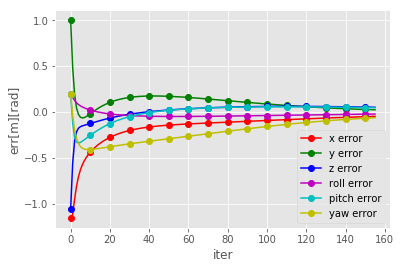

In [48]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(range(x_err.shape[1]),x_err.row(0).T, 'r', marker='o',markevery=10, label="x error")
plt.plot(range(x_err.shape[1]),x_err.row(1).T, 'g', marker='o',markevery=10, label="y error")
plt.plot(range(x_err.shape[1]),x_err.row(2).T, 'b', marker='o',markevery=10, label="z error")
plt.plot(range(x_err.shape[1]),x_err.row(3).T, 'm', marker='o',markevery=10, label="roll error")
plt.plot(range(x_err.shape[1]),x_err.row(4).T, 'c', marker='o',markevery=10, label="pitch error")
plt.plot(range(x_err.shape[1]),x_err.row(5).T, 'y', marker='o',markevery=10, label="yaw error")
plt.xlabel("iter")
plt.ylabel("err[m][rad]")
plt.legend()

## 4 ROS Integration

In [12]:
from geometry_msgs.msg import Pose
from trajectory_msgs.msg import JointTrajectoryPoint
import tf

############ ROS SERVICE SIMULATION############
class request_fake():
    def __init__(self):
        self.poses = [Pose()]
        self.poses[0].position.x = 1
        self.poses[0].position.y = 1
        self.poses[0].position.z = 1
###############################################

req = request_fake()

for x in xrange(0, len(req.poses)):
    # IK code starts here
    joint_trajectory_point = JointTrajectoryPoint()

    # Extract end-effector position and orientation from request
    # px,py,pz = end-effector position
    # roll, pitch, yaw = end-effector orientation
    px = req.poses[x].position.x
    py = req.poses[x].position.y
    pz = req.poses[x].position.z

    (roll, pitch, yaw) = tf.transformations.euler_from_quaternion(
                            [req.poses[x].orientation.x, req.poses[x].orientation.y,
                            req.poses[x].orientation.z, req.poses[x].orientation.w])

Sources:
    
* https://github.com/udacity/RoboND-Kinematics-Project
    
* https://jychstar.blogspot.com/2017/09/robot-nd-a2-kinematics.html